In [184]:
import ray.tune
from pathlib import Path
from dataclasses import dataclass, field
from functools import lru_cache
import pandas as pd
from typing import List
from functools import partial
import seaborn as sns

In [2]:
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

In [3]:
from etr_fr_expes import metric

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ledoyen202/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
EXPE_DIR = Path("../../experimentations/").resolve()
ICL_EXPE_DIR = EXPE_DIR / "icl_experimentations"

In [5]:
ETRMetrics = metric.ETRMetrics("fr")

In [275]:
@dataclass
class Expe:
    model: str
    method: str
    task: str
    train_tasks: str
    metric: str
    mode: str
    adapter_name: str
    split: str = "eval"
    expe_dir: str = EXPE_DIR
    step: str = "hp_search"
    _expe_analysis = None
    
    
    @property
    def base_columns(self):
        return [
            # "expe",
            "trial_id",
            "model", 
            "method", 
            "task", 
            "train_tasks", 
            # "metric",
        ]
    
    @property
    def expe_name(self):
        return f"{self.model}.{self.method}.{self.train_tasks}"
    
    @property
    def expe_analysis(self):
        step = f"_{self.step}" if self.step else ""
        hp_search_dir = self.expe_dir / self.expe_name / "results" / f"{self.expe_name}{step}"
        if self._expe_analysis is None:
            self._expe_analysis = ray.tune.ExperimentAnalysis(hp_search_dir)
        return self._expe_analysis
    
    @property
    def dfs(self):
        return self.expe_analysis.trial_dataframes

    @property
    def dataframe(self):
        dfs = self.dfs
        res = (pd.concat(dfs, ignore_index=True)
            .reset_index(level=0)
            .assign(
                expe=self.expe_name, 
                model=self.model, 
                metric=self.metric,
                method=self.method,
                task=self.task,
                train_tasks=self.train_tasks,
            )
            .sort_values(by=f"{self.split}_{self.metric}", ascending=self.mode == "min")
            .rename(columns=lambda x: x.replace(self.adapter_name, 'adapter'))
        )
        res = res.set_index(self.base_columns)
        return res
    
    def metric_columns(self, _type="test"):
        return self.dataframe.filter(
            regex=f"{_type}_{self.task}_(?!texts)"
        ).columns
        
    def text_columns(self, _type="test"):
        return self.dataframe.filter(
            regex=f"{_type}.*texts"
        ).columns
        
    @property
    def test_metric_df(self):
        return self.dataframe[self.metric_columns(_type="test")]
    
    @property
    def eval_metric_df(self):
        return self.dataframe[self.metric_columns(_type="eval")]
    
    @property
    def best_model(self):
        return self.dataframe.iloc[0]
    
    def get_texts_df(self, row_idx, _type="test"):
        row_df = self.dataframe.iloc[row_idx].filter(regex=f"{_type}.*texts").to_frame().T
        row_df = row_df.explode(list(row_df.columns)).reset_index(drop=True).stack().to_frame()
        return row_df
    
    @property
    def best_trial(self):
        return self.expe_analysis.get_best_trial(metric=self.metric, mode=self.mode, scope="all")
    
@dataclass
class RAGExpe(Expe):
    
    @property
    def dfs(self):
        return [self.expe_analysis.dataframe()]
    
    def get_best_df(self, df):
        best_idx = df["eval_etr_fr_srb"].idxmax()
        config_columns = list(df.filter(regex="icl_config").columns)
        best_config = df.loc[best_idx, config_columns]
        return df[df[config_columns].eq(best_config).all(axis=1)]

    @property
    def dataframe(self):
        res = super().dataframe
        res = self.get_best_df(res)
        return res
    
    
ETRFrExpe = partial(Expe, metric="etr_fr_srb", mode="max", task="etr_fr", adapter_name="lora_etr_fr")
RAGETRFrExpe = partial(RAGExpe, metric="etr_fr_srb", mode="max", task="etr_fr", adapter_name="lora_etr_fr")

OrangesumExpe = partial(Expe, metric="orangesum_rougeL", mode="max", task="orangesum", adapter_name="lora_orangesum")
WikilargeExpe = partial(Expe, metric="wikilarge_fr_sari", mode="max", task="wikilarge_fr")

In [276]:
@dataclass
class Analysis:
    expes: List['Expe']
    metrics: List[str] = field(default_factory=lambda: [
        "rouge1",
        "rouge2",
        "rougeL",
        "sari",
        "bertscore_f1",
        "srb",
        "compression_ratio",
        "novelty",
        "kmre",
        "lix"
    ])

    model_order = ['mbarthez', 'llama3', 'mistral']
    tasks_order = [
        ('lora', 'etrfr'),
        ('mtllora', 'etrfr+orangesum+wikilarge'),
        ('mtllora', 'etrfr+orangesum'),
        ('mtllora', 'etrfr+wikilarge')
    ]

    def _sort_df_by_model_and_tasks(self, df):
        model_map = {k: i for i, k in enumerate(self.model_order)}
        tasks_map = {k: i for i, k in enumerate(self.tasks_order)}

        index_df = pd.DataFrame(df.index.tolist(), columns=['model', 'adapter', 'tasks'])

        index_df['model_order'] = index_df['model'].map(model_map)
        index_df['tasks_tuple'] = list(zip(index_df['adapter'], index_df['tasks']))
        index_df['tasks_order'] = index_df['tasks_tuple'].map(tasks_map)

        sorted_index = pd.MultiIndex.from_frame(
            index_df.sort_values(['model_order', 'tasks_order']).drop(columns=['model_order', 'tasks_order', 'tasks_tuple'])
        )

        return df.reindex(sorted_index)

    def _standardize_column_multiindex(self, df, groups=None, separator="_"):
        if groups is None:
            groups = []

        groups = sorted(groups, key=len, reverse=True)

        new_cols = []
        for metric, stat in df.columns:
            matched_group = "other"
            short_name = metric

            for group in groups:
                if metric.startswith(group + separator):
                    matched_group = group
                    short_name = metric[len(group) + 1:]
                    break

            new_cols.append((matched_group, short_name, stat))

        df.columns = pd.MultiIndex.from_tuples(new_cols, names=['group', 'metric', 'stat'])
        return df

    def _format_mean_std_with_bold(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Format mean ± std as LaTeX, and bold the best (max) mean per (group, metric).
        """
        # Ensure it's a MultiIndex with a 'stat' level
        if 'stat' not in df.columns.names:
            raise ValueError("Expected MultiIndex columns with 'stat' level")

        mean = df.xs('mean', level='stat', axis=1)
        std = df.xs('std', level='stat', axis=1)

        # Determine the max mean index per column
        max_idx = mean.idxmax()

        # Build formatted DataFrame
        formatted = pd.DataFrame(index=mean.index, columns=mean.columns)

        for col in mean.columns:
            for idx in mean.index:
                m = mean.at[idx, col]
                s = std.at[idx, col]

                if idx == max_idx[col]:
                    formatted.at[idx, col] = f"$\\mathbf{{{m:.2f}}}_{{\\pm{s:.2f}}}$"
                else:
                    formatted.at[idx, col] = f"${m:.2f}_{{\\pm{s:.2f}}}$"

        return formatted

    def reorder_metrics(self, df: pd.DataFrame) -> pd.DataFrame:
        """Reorders and filters MultiIndex columns by desired metrics. Supports 2 or 3 levels."""
        desired_order = self.metrics
        order_map = {metric: i for i, metric in enumerate(desired_order)}

        if isinstance(df.columns, pd.MultiIndex):
            num_levels = df.columns.nlevels

            if num_levels == 3:
                filtered_columns = [col for col in df.columns if col[1] in order_map]
                sorted_columns = sorted(filtered_columns, key=lambda col: (
                    col[0], order_map[col[1]], col[2]
                ))
            elif num_levels == 2:
                filtered_columns = [col for col in df.columns if col[1] in order_map]
                sorted_columns = sorted(filtered_columns, key=lambda col: (
                    col[0], order_map[col[1]]
                ))
            else:
                raise ValueError("Unsupported column MultiIndex depth.")

            return df[sorted_columns]

        else:
            # Not a MultiIndex – optionally filter if plain column names match metrics
            filtered_columns = [col for col in df.columns if col in order_map]
            sorted_columns = sorted(filtered_columns, key=lambda col: order_map[col])
            return df[sorted_columns]
    
    @property
    def dataframe(self):
        dfs = [expe.dataframe for expe in self.expes]
        return pd.concat(dfs)

    def best_models(self, _type=None, texts=False):
        series = [expe.best_model for expe in self.expes]
        res = pd.DataFrame(series)

        return_metrics = _type in ["test", "eval"]
        if not texts and return_metrics:
            res = res.filter(regex=f"{_type}.*({'|'.join(self.metrics)})")
        elif return_metrics:
            cols = self.expes[0].text_columns(_type=_type)
            res = res[cols]

        return res

    def mean_models(self, _type="test", texts=False):
        res = self.dataframe

        return_metrics = _type in ["test", "eval"]
        if not texts and return_metrics:
            res = res.filter(regex=f"{_type}.*({'|'.join(self.metrics)})")
        elif return_metrics:
            cols = self.expes[0].text_columns(_type=_type)
            res = res[cols]

        res = (res
               .groupby(["model", "method", "train_tasks"])
               .agg(['mean', 'std'])
               .round(2)
        )

        res = self._sort_df_by_model_and_tasks(res)
        res = self._standardize_column_multiindex(res, groups=["test_etr_fr_politic", "test_etr_fr"])
        res = res.groupby(level="model", sort=False).apply(lambda x: self._format_mean_std_with_bold(x))
        res = self.reorder_metrics(res)
        res = res.droplevel(0)

        return res

    @property
    def test_metrics(self):
        return self.best_models(_type="test")

    @property
    def eval_metrics(self):
        return self.best_models(_type="eval")

    @property
    def test_texts(self):
        return self.best_models(_type="test", texts=True)


In [277]:
MBARTHEZ, MBART, MISTRAL, LLAMA3 = "mbarthez", "mbart", "mistral", "llama3"
DEEPSEEK = "deepseekr1"
LORA, MTLLORA = "lora", "mtllora"
ETR_FR, ORANGESUM, WIKILARGE, ETR_FR_ORANGESUM, ETR_FR_WIKILARGE, ALL = "etrfr", "orangesum", "wikilarge", "etrfr+orangesum", "etrfr+wikilarge", "etrfr+orangesum+wikilarge"

In [278]:
etr_fr_analysis = Analysis(
    expes=[        
        ETRFrExpe(model=MBARTHEZ, method=LORA, train_tasks=ETR_FR),
        ETRFrExpe(model=MBARTHEZ, method=MTLLORA, train_tasks=ALL),
        ETRFrExpe(model=MBARTHEZ, method=MTLLORA, train_tasks=ETR_FR_ORANGESUM),
        ETRFrExpe(model=MBARTHEZ, method=MTLLORA, train_tasks=ETR_FR_WIKILARGE),
        
        ETRFrExpe(model=LLAMA3, method=LORA, train_tasks=ETR_FR),
        ETRFrExpe(model=LLAMA3, method=MTLLORA, train_tasks=ALL),
        ETRFrExpe(model=LLAMA3, method=MTLLORA, train_tasks=ETR_FR_ORANGESUM),
        ETRFrExpe(model=LLAMA3, method=MTLLORA, train_tasks=ETR_FR_WIKILARGE),
        
        ETRFrExpe(model=MISTRAL, method=LORA, train_tasks=ETR_FR),
        ETRFrExpe(model=MISTRAL, method=MTLLORA, train_tasks=ALL),
        ETRFrExpe(model=MISTRAL, method=MTLLORA, train_tasks=ETR_FR_ORANGESUM),
        ETRFrExpe(model=MISTRAL, method=MTLLORA, train_tasks=ETR_FR_WIKILARGE),
        
        ETRFrExpe(model=DEEPSEEK, method=LORA, train_tasks=ETR_FR),
        ETRFrExpe(model=DEEPSEEK, method=MTLLORA, train_tasks=ALL),
        ETRFrExpe(model=DEEPSEEK, method=MTLLORA, train_tasks=ETR_FR_ORANGESUM),
        ETRFrExpe(model=DEEPSEEK, method=MTLLORA, train_tasks=ETR_FR_WIKILARGE),
    ]
)

wikilarge_analysis = Analysis(
    expes=[
        WikilargeExpe(model=MBARTHEZ, method=LORA, train_tasks="wikilarge-fr", adapter_name="lora_wikilarge_fr"),
        WikilargeExpe(model=LLAMA3, method=LORA, train_tasks=WIKILARGE, adapter_name="lora_wikilarge"),
        WikilargeExpe(model=MISTRAL, method=LORA, train_tasks=WIKILARGE, adapter_name="lora_wikilarge"),
    ]
)

orangesum_analysis = Analysis(
    expes=[
        OrangesumExpe(model=MBARTHEZ, method=LORA, train_tasks=ORANGESUM),
        OrangesumExpe(model=LLAMA3, method=LORA, train_tasks=ORANGESUM),
        OrangesumExpe(model=MISTRAL, method=LORA, train_tasks=ORANGESUM),
    ]
)



In [279]:
etr_fr_analysis.eval_metrics

,,,,,eval_etr_fr_rouge1,eval_etr_fr_rouge2,eval_etr_fr_rougeL,eval_etr_fr_rougeLsum,eval_etr_fr_sari,eval_etr_fr_bertscore_f1_rescaled,eval_etr_fr_bertscore_f1,eval_etr_fr_kmre,eval_etr_fr_lix,eval_etr_fr_compression_ratio,eval_etr_fr_novelty,eval_etr_fr_srb
eec88_00003,mbarthez,lora,etr_fr,etrfr,42.0699,18.9869,31.6116,40.2960,43.5779,36.4343,76.1787,99.4551,26.7680,46.9893,18.6687,44.3077
0e965_00009,mbarthez,mtllora,etr_fr,etrfr+orangesum+wikilarge,42.8477,19.5226,32.1822,40.9599,44.2588,37.9894,76.7615,98.5026,27.7983,46.3988,20.5952,44.9810
dc655_00009,mbarthez,mtllora,etr_fr,etrfr+orangesum,40.7273,18.8030,30.9719,39.0222,43.2281,35.1582,75.7005,98.5344,27.2011,47.7912,14.3958,43.7124
d12fe_00011,mbarthez,mtllora,etr_fr,etrfr+wikilarge,40.3888,17.6510,30.3948,38.6655,42.0696,34.5524,75.4735,97.4215,28.8777,42.7687,12.2696,42.9061
8a9fd_00003,llama3,lora,etr_fr,etrfr,42.1720,20.2764,32.7097,40.5270,45.9699,36.7264,76.2882,95.3582,29.0824,45.7141,22.3861,45.8481
a6a20_00009,llama3,mtllora,etr_fr,etrfr+orangesum+wikilarge,43.3292,21.9895,33.9438,41.9159,49.4661,39.8132,77.4450,97.4047,27.8156,49.0110,35.2361,47.9320
e160e_00010,llama3,mtllora,etr_fr,etrfr+orangesum,44.5968,22.5648,34.6758,42.8946,50.6565,39.9974,77.5140,98.3807,26.6145,50.0887,36.4972,48.7962
f2da7_00011,llama3,mtllora,etr_fr,etrfr+wikilarge,43.9325,20.8832,33.5480,41.8511,48.8374,39.0993,77.1775,98.3391,26.9670,50.2579,35.2471,47.4373
142d8_00003,mistral,lora,etr_fr,etrfr,42.2985,20.2579,32.1511,40.1984,47.4291,37.1022,76.4290,97.4827,27.5085,47.3911,28.1271,45.9620
fc28b_00009,mistral,mtllora,etr_fr,etrfr+orangesum+wikilarge,44.3640,21.5359,33.9146,42.3962,48.8829,39.1615,77.2008,97.6679,28.3413,48.0869,30.1270,47.6977


In [280]:
etr_fr_analysis.test_metrics

,,,,,test_etr_fr_rouge1,test_etr_fr_rouge2,test_etr_fr_rougeL,test_etr_fr_rougeLsum,test_etr_fr_sari,test_etr_fr_bertscore_f1_rescaled,test_etr_fr_bertscore_f1,test_etr_fr_kmre,test_etr_fr_lix,test_etr_fr_compression_ratio,test_etr_fr_novelty,test_etr_fr_srb
eec88_00003,mbarthez,lora,etr_fr,etrfr,32.7543,11.3156,23.2567,32.0457,40.4355,29.5419,73.5958,103.3008,24.8117,54.9941,10.4452,36.8927
0e965_00009,mbarthez,mtllora,etr_fr,etrfr+orangesum+wikilarge,33.0490,10.8312,22.6129,31.9181,40.0726,29.7148,73.6606,103.4382,25.1143,55.1754,12.9713,36.2525
dc655_00009,mbarthez,mtllora,etr_fr,etrfr+orangesum,31.4234,10.9910,21.9421,30.6070,39.7870,28.4279,73.1783,103.4014,25.2632,58.1807,8.1990,35.5562
d12fe_00011,mbarthez,mtllora,etr_fr,etrfr+wikilarge,31.4454,10.5748,22.0464,30.5114,39.7474,28.0574,73.0395,102.1342,25.8955,51.1051,7.7199,35.6256
8a9fd_00003,llama3,lora,etr_fr,etrfr,32.5740,13.3147,25.4039,31.6790,42.3580,27.8567,72.9643,101.2611,26.6041,55.9325,17.6872,39.1248
a6a20_00009,llama3,mtllora,etr_fr,etrfr+orangesum+wikilarge,33.0898,14.3247,25.7050,32.2739,44.3220,30.5307,73.9664,101.9018,25.7013,56.5829,24.6053,40.0081
e160e_00010,llama3,mtllora,etr_fr,etrfr+orangesum,33.0561,13.1307,25.2967,32.2475,43.8882,29.9372,73.7440,102.6062,25.6946,58.3828,27.0507,39.5380
f2da7_00011,llama3,mtllora,etr_fr,etrfr+wikilarge,32.8271,13.3691,25.1785,32.0944,43.0800,28.9948,73.3908,102.1736,25.6960,59.9341,27.2829,39.1876
142d8_00003,mistral,lora,etr_fr,etrfr,33.0512,12.4423,23.9149,31.8074,42.3321,29.2774,73.4967,102.5652,24.7447,56.1678,17.9289,37.9537
fc28b_00009,mistral,mtllora,etr_fr,etrfr+orangesum+wikilarge,35.0767,13.1091,25.4820,33.7238,42.5381,30.5320,73.9669,102.0032,25.7134,57.1174,22.6994,39.3333


In [281]:
ETRMetrics.compute?

Signature: ETRMetrics.compute(predictions, references, sources)
Docstring: <no docstring>
File:      ~/Documents/labo/etr-peft-composition/src/etr_fr_expes/metric.py
Type:      method

In [282]:
import numpy as np

In [283]:
def compute_metrics(text_df, n_examples):
    text_df = text_df.unstack().droplevel(0, axis=1)
    text_df.columns = text_df.columns.str.split('/').str[-1]
    return (text_df
     .apply(
        lambda x: ETRMetrics([x.predictions], [x.labels], [x.inputs]),
        axis=1,
        result_type='expand'
     ).iloc[:n_examples]
    )

In [284]:
def bootstrap_ci(metrics_df, num_samples=1000, ci=0.95):
    n = len(metrics_df)
    scores = []
    for _ in range(num_samples):
        indices = np.random.choice(n, n, replace=True)
        metrics = metrics_df.iloc[indices]
        scores.append(metrics.mean())
    scores = pd.concat(scores, axis=1).T
    lower = np.percentile(scores, [(1 - ci)/2 * 100, (1 + ci)/2 * 100])
    upper = np.percentile(scores, (1 + ci) / 2 * 100)
    return scores.mean(), scores.std(), lower, upper

def paired_bootstrap(metrics_sys, metrics_baseline, num_samples=1000):
    n = len(metrics_sys)
    diffs = []
    for _ in range(num_samples):
        idxs = np.random.choice(n, n, replace=True)
        sampled_sys = metrics_sys.iloc[idxs]
        sampled_base = metrics_baseline.iloc[idxs]
        diff = sampled_sys.mean() - sampled_base.mean()
        diffs.append(diff)

    diffs = pd.concat(diffs, axis=1).T
    p_value = (diffs <= 0).sum() / num_samples
    return p_value


In [285]:
# metrics_a = compute_metrics(etr_fr_analysis.expes[4].get_texts_df(0),53)
# metrics_b = compute_metrics(etr_fr_analysis.expes[5].get_texts_df(0),53)

In [286]:
# paired_bootstrap(metrics_b, metrics_a, 1000) < 0.05

In [292]:
def get_rag_expes():
    models = ["mistral-7b", "llama3-8b"]
    methods_tasks = [
        ("zero_shot", [ETR_FR]),
        ("rag", [ETR_FR, ETR_FR_ORANGESUM, ETR_FR_WIKILARGE, ALL])
    ]

    return [
        RAGETRFrExpe(model=model, method=method, train_tasks=task, step="", expe_dir=ICL_EXPE_DIR)
        for model in models
        for method, task_list in methods_tasks
        for task in task_list if method == "rag" or task == ETR_FR
    ]

def get_mtl_expes():
    models = [
        MBARTHEZ, 
        LLAMA3, 
        MISTRAL,
        # DEEPSEEK
    ]
    methods = [LORA, MTLLORA]
    train_tasks_sets = {
        LORA: [ETR_FR],
        MTLLORA: [ALL, ETR_FR_ORANGESUM, ETR_FR_WIKILARGE]
    }

    return [
        ETRFrExpe(model=model, method=method, train_tasks=train_tasks, step="test_best_model", split="test")
        for model in models
        for method in methods
        for train_tasks in train_tasks_sets[method]
    ]
    

In [293]:
etr_fr_analysis_test_best_model = Analysis(
    expes=[    
        *get_rag_expes(),
        *get_mtl_expes(),
    ]
)

In [294]:
res_df = etr_fr_analysis_test_best_model.mean_models()
res_df

group                                                          test_etr_fr  \
metric                                                              rouge1   
model      adapter   tasks                                                   
mbarthez   lora      etrfr                               $32.75_{\pm0.06}$   
           mtllora   etrfr+orangesum+wikilarge  $\mathbf{32.94}_{\pm0.09}$   
                     etrfr+orangesum                     $32.31_{\pm0.10}$   
                     etrfr+wikilarge                     $31.35_{\pm0.05}$   
llama3     lora      etrfr                               $31.80_{\pm0.03}$   
           mtllora   etrfr+orangesum+wikilarge           $32.78_{\pm0.02}$   
                     etrfr+orangesum            $\mathbf{33.38}_{\pm0.06}$   
                     etrfr+wikilarge                     $32.54_{\pm0.05}$   
mistral    lora      etrfr                               $32.45_{\pm0.03}$   
           mtllora   etrfr+orangesum+wikilarge  $\mathbf{33.60}_{\pm0.05}$   
                     etrfr+orangesum                     $32.62_{\pm0.04}$   
                     etrfr+wikilarge                     $32.68_{\pm0.05}$   
llama3-8b  rag       etrfr                      $\mathbf{32.14}_{\pm0.44}$   
                     etrfr+orangesum                     $30.77_{\pm0.35}$   
                     etrfr+orangesum+wikilarge           $30.53_{\pm0.74}$   
                     etrfr+wikilarge                     $32.14_{\pm0.56}$   
mistral-7b rag       etrfr                      $\mathbf{31.97}_{\pm0.30}$   
                     etrfr+orangesum                     $30.36_{\pm0.47}$   
                     etrfr+orangesum+wikilarge           $29.85_{\pm0.04}$   
                     etrfr+wikilarge                     $30.46_{\pm0.48}$   
           zero_shot etrfr                               $23.96_{\pm0.04}$   

group                                                                       \
metric                                                              rouge2   
model      adapter   tasks                                                   
mbarthez   lora      etrfr                      $\mathbf{11.50}_{\pm0.03}$   
           mtllora   etrfr+orangesum+wikilarge           $11.36_{\pm0.01}$   
                     etrfr+orangesum                     $10.91_{\pm0.04}$   
                     etrfr+wikilarge                     $10.62_{\pm0.02}$   
llama3     lora      etrfr                               $13.16_{\pm0.09}$   
           mtllora   etrfr+orangesum+wikilarge  $\mathbf{13.67}_{\pm0.03}$   
                     etrfr+orangesum                     $13.16_{\pm0.05}$   
                     etrfr+wikilarge                     $13.50_{\pm0.06}$   
mistral    lora      etrfr                               $12.38_{\pm0.02}$   
           mtllora   etrfr+orangesum+wikilarge           $12.81_{\pm0.05}$   
                     etrfr+orangesum                     $12.73_{\pm0.01}$   
                     etrfr+wikilarge            $\mathbf{12.91}_{\pm0.01}$   
llama3-8b  rag       etrfr                      $\mathbf{11.71}_{\pm0.42}$   
                     etrfr+orangesum                     $10.85_{\pm0.31}$   
                     etrfr+orangesum+wikilarge           $10.67_{\pm0.45}$   
                     etrfr+wikilarge                     $11.70_{\pm0.34}$   
mistral-7b rag       etrfr                      $\mathbf{10.36}_{\pm0.39}$   
                     etrfr+orangesum                      $9.61_{\pm0.34}$   
                     etrfr+orangesum+wikilarge            $9.58_{\pm0.03}$   
                     etrfr+wikilarge                      $9.93_{\pm0.17}$   
           zero_shot etrfr                                $7.08_{\pm0.01}$   

group                                                                       \
metric                                                              rougeL   
model      adapter   tasks                                                   
mbarthez   lora     

### RAG

In [274]:
rag_analysis.expes[2].dataframe

,,,,,index,eval_etr_fr_rouge1,eval_etr_fr_rouge2,eval_etr_fr_rougeL,eval_etr_fr_rougeLsum,eval_etr_fr_sari,eval_etr_fr_bleu,eval_etr_fr_bertscore_f1_rescaled,eval_etr_fr_bertscore_recall_rescaled,eval_etr_fr_bertscore_precision_rescaled,...,config/icl_config/prompt_template/input_prompt,config/icl_config/prompt_template/shot_template,config/icl_config/prompt_template/output_prefix,config/icl_config/task_to_name/etr_fr,config/icl_config/task_to_name/etr_fr_politic,config/icl_config/task_to_name/orangesum,config/icl_config/task_to_name/wikilarge_fr,logdir,expe,metric
trial_id,model,method,task,train_tasks,,,,,,,,,,,,,,,,,,,,,
378a8_00044,mistral-7b,rag,etr_fr,etrfr+orangesum,44,41.0054,17.9785,30.8139,39.2804,43.6396,10.8117,35.4850,37.8084,33.3059,...,Tâche: {task}\nEntrée: {input}\nSortie:,### Exemple {i}\nTâche: {task}\nEntrée: {input}\nSortie: @@@{output}@@@,@@@,FALC,FALC,Résumé,Simplification,378a8_00044,mistral-7b.rag.etrfr+orangesum,etr_fr_srb
378a8_00035,mistral-7b,rag,etr_fr,etrfr+orangesum,35,40.3493,17.5556,29.5632,38.9040,43.0253,9.7225,34.4933,36.9018,32.2176,...,Tâche: {task}\nEntrée: {input}\nSortie:,### Exemple {i}\nTâche: {task}\nEntrée: {input}\nSortie: @@@{output}@@@,@@@,FALC,FALC,Résumé,Simplification,378a8_00035,mistral-7b.rag.etrfr+orangesum,etr_fr_srb
378a8_00026,mistral-7b,rag,etr_fr,etrfr+orangesum,26,39.8086,17.0694,29.5106,38.3067,42.9023,10.0147,34.6276,37.2971,32.1558,...,Tâche: {task}\nEntrée: {input}\nSortie:,### Exemple {i}\nTâche: {task}\nEntrée: {input}\nSortie: @@@{output}@@@,@@@,FALC,FALC,Résumé,Simplification,378a8_00026,mistral-7b.rag.etrfr+orangesum,etr_fr_srb
378a8_00008,mistral-7b,rag,etr_fr,etrfr+orangesum,8,39.8918,17.3545,29.3573,38.2178,42.8315,7.0925,33.8698,36.3352,31.5885,...,Tâche: {task}\nEntrée: {input}\nSortie:,### Exemple {i}\nTâche: {task}\nEntrée: {input}\nSortie: @@@{output}@@@,@@@,FALC,FALC,Résumé,Simplification,378a8_00008,mistral-7b.rag.etrfr+orangesum,etr_fr_srb
378a8_00017,mistral-7b,rag,etr_fr,etrfr+orangesum,17,39.4822,17.2159,29.2497,38.0280,42.5718,9.7135,34.5506,37.0508,32.2601,...,Tâche: {task}\nEntrée: {input}\nSortie:,### Exemple {i}\nTâche: {task}\nEntrée: {input}\nSortie: @@@{output}@@@,@@@,FALC,FALC,Résumé,Simplification,378a8_00017,mistral-7b.rag.etrfr+orangesum,etr_fr_srb


In [205]:
df = rag_expes[4].expe_analysis.dataframe()

In [206]:
df = df.map(lambda x: tuple(x) if isinstance(x, list) else x)

<Axes: xlabel='config/icl_config/k', ylabel='eval_etr_fr_srb'>

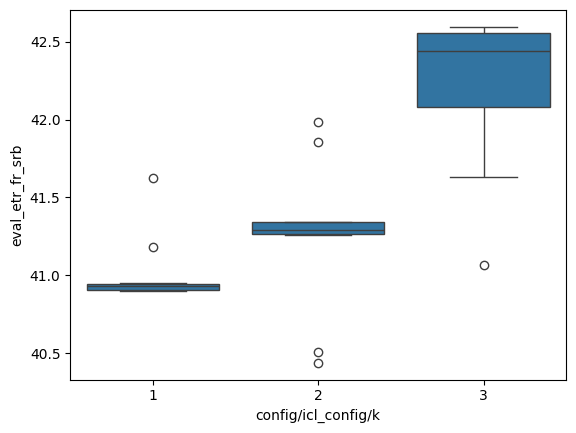

In [207]:
sns.boxplot(data=df, x="config/icl_config/k", y="eval_etr_fr_srb", dodge=True)